# F1 Fastest Race Lap Predictions

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [217]:
import kagglehub

quali_path = kagglehub.dataset_download(
    "rohanrao/formula-1-world-championship-1950-2020",
    path='qualifying.csv'
)
races_path = kagglehub.dataset_download(
    "rohanrao/formula-1-world-championship-1950-2020",
    path='races.csv'
)
results_path = kagglehub.dataset_download(
    "rohanrao/formula-1-world-championship-1950-2020",
    path='results.csv'
)
drivers_path = kagglehub.dataset_download(
    "rohanrao/formula-1-world-championship-1950-2020",
    path='drivers.csv'
)
constructors_path = kagglehub.dataset_download(
    "rohanrao/formula-1-world-championship-1950-2020",
    path='constructors.csv'
)

print("Path to dataset files:", races_path, quali_path, results_path, drivers_path, constructors_path, sep='\n')

Path to dataset files:
/home/sofi/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/races.csv
/home/sofi/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/qualifying.csv
/home/sofi/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/results.csv
/home/sofi/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/drivers.csv
/home/sofi/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/constructors.csv


## Dataframe Creation

In [218]:
quali = pd.read_csv(
    quali_path,
    index_col='qualifyId',
    na_values='\\N'
)
quali.head(5)

,raceId,driverId,constructorId,number,position,q1,q2,q3
qualifyId,,,,,,,,
1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
5,18,2,2,3,5,1:25.960,1:25.518,1:27.236


In [219]:
races = pd.read_csv(
    races_path,
    index_col='raceId',
    parse_dates=['date'],
    na_values='\\N'
)
races.head(5)

,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
raceId,,,,,,,,,,,,,,,,,
1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [220]:
race_results = pd.read_csv(
    results_path,
    index_col='resultId',
    na_values='\\N'
)
race_results.head(5)

,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
resultId,,,,,,,,,,,,,,,,,
1,18,1,1,22.0,1,1.0,1,1,10.0,58,1:34:50.616,5690616.0,39.0,2.0,1:27.452,218.300,1
2,18,2,2,3.0,5,2.0,2,2,8.0,58,+5.478,5696094.0,41.0,3.0,1:27.739,217.586,1
3,18,3,3,7.0,7,3.0,3,3,6.0,58,+8.163,5698779.0,41.0,5.0,1:28.090,216.719,1
4,18,4,4,5.0,11,4.0,4,4,5.0,58,+17.181,5707797.0,58.0,7.0,1:28.603,215.464,1
5,18,5,1,23.0,3,5.0,5,5,4.0,58,+18.014,5708630.0,43.0,1.0,1:27.418,218.385,1


In [221]:
drivers = pd.read_csv(
    drivers_path,
    index_col='driverId',
    na_values='\\N'
)
drivers.head(5)

,driverRef,number,code,forename,surname,dob,nationality,url
driverId,,,,,,,,
1,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
2,heidfeld,NaN,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
3,rosberg,6.0,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
4,alonso,14.0,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
5,kovalainen,NaN,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [222]:
constructors = pd.read_csv(
    constructors_path,
    index_col='constructorId'
)
constructors

,constructorRef,name,nationality,url
constructorId,,,,
1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso
...,...,...,...,...
210,haas,Haas F1 Team,American,http://en.wikipedia.org/wiki/Haas_F1_Team
211,racing_point,Racing Point,British,http://en.wikipedia.org/wiki/Racing_Point_F1_Team
213,alphatauri,AlphaTauri,Italian,http://en.wikipedia.org/wiki/Scuderia_AlphaTauri


## Ground effect cars era (2022–2025)

In [223]:
races = races.loc[(races['year'] >= 2022) & (races['year'] <= 2024)]
races = races[['year', 'name']]
races.head(5)

,year,name
raceId,,
1074,2022,Bahrain Grand Prix
1075,2022,Saudi Arabian Grand Prix
1076,2022,Australian Grand Prix
1077,2022,Emilia Romagna Grand Prix
1078,2022,Miami Grand Prix


In [224]:
def lap_time_to_seconds(time):
    if pd.isna(time):
        return np.nan
    minutes, seconds = time.split(':')
    return int(minutes) * 60 + float(seconds)

In [225]:
data = races.merge(quali[['raceId', 'driverId', 'q1', 'q2', 'q3']], on='raceId')
data = data.merge(race_results[['raceId', 'driverId', 'constructorId', 'fastestLapTime']], on=['raceId', 'driverId'])
data = data.merge(drivers['surname'], on='driverId')
data = data.merge(constructors['name'], suffixes=('_race', '_constructor'), on='constructorId')

In [226]:
data = data.dropna(subset='fastestLapTime')
data = data.dropna(subset=['q1', 'q2', 'q3'], how='all')
data = data.drop(['driverId', 'constructorId', 'raceId'], axis=1)

In [227]:
for col in ['q1', 'q2', 'q3', 'fastestLapTime']:
    data[col] = data[col].apply(lap_time_to_seconds)

data['bestQualiTime'] = data[['q1', 'q2', 'q3']].min(axis=1, skipna=True)

In [228]:
numeric_vars = ['bestQualiTime']
categorical_vars = ['surname', 'name_constructor']

In [229]:
data['surname'].unique()

array(['Leclerc', 'Verstappen', 'Sainz', 'Pérez', 'Hamilton', 'Bottas',
       'Magnussen', 'Alonso', 'Russell', 'Gasly', 'Ocon', 'Schumacher',
       'Norris', 'Albon', 'Zhou', 'Tsunoda', 'Hülkenberg', 'Ricciardo',
       'Stroll', 'Latifi', 'Vettel', 'de Vries', 'Sargeant', 'Piastri',
       'Lawson', 'Bearman', 'Colapinto', 'Doohan'], dtype=object)

In [230]:
data['name_constructor'].unique()

array(['Ferrari', 'Red Bull', 'Mercedes', 'Alfa Romeo', 'Haas F1 Team',
       'Alpine F1 Team', 'AlphaTauri', 'McLaren', 'Williams',
       'Aston Martin', 'RB F1 Team', 'Sauber'], dtype=object)

# Dataset Analysis

In [ ]:
# TODO: add more

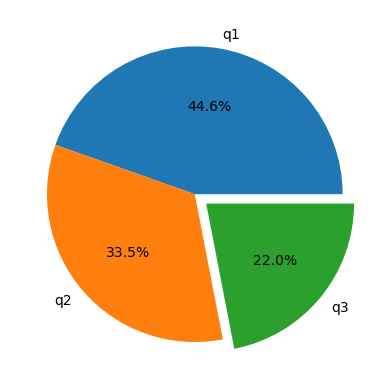

In [231]:
plt.pie(
    data[['q1', 'q2', 'q3']].count(),
    labels=['q1', 'q2', 'q3'],
    autopct='%1.1f%%',
    explode=(0, 0, 0.1)
);

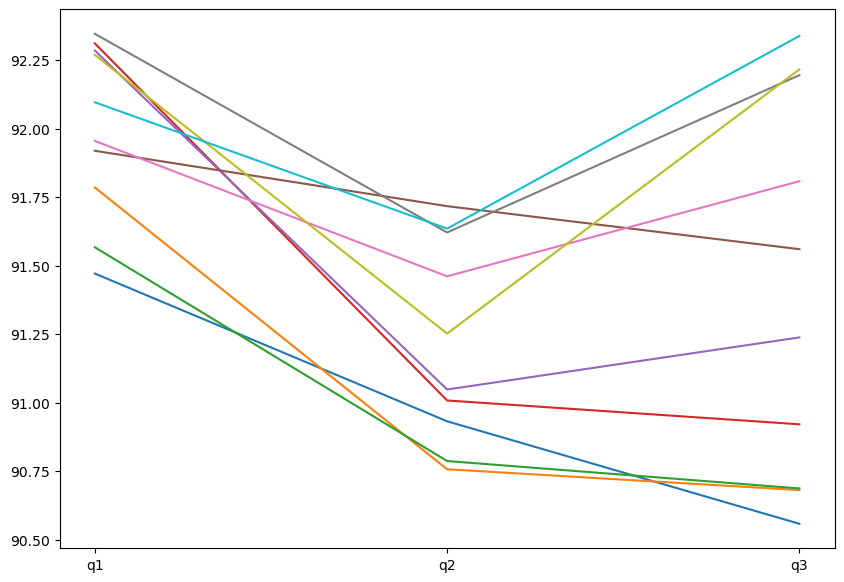

In [232]:
plt.figure(figsize=(10, 7))
plt.plot(data[['q1', 'q2', 'q3']].head(10).T);

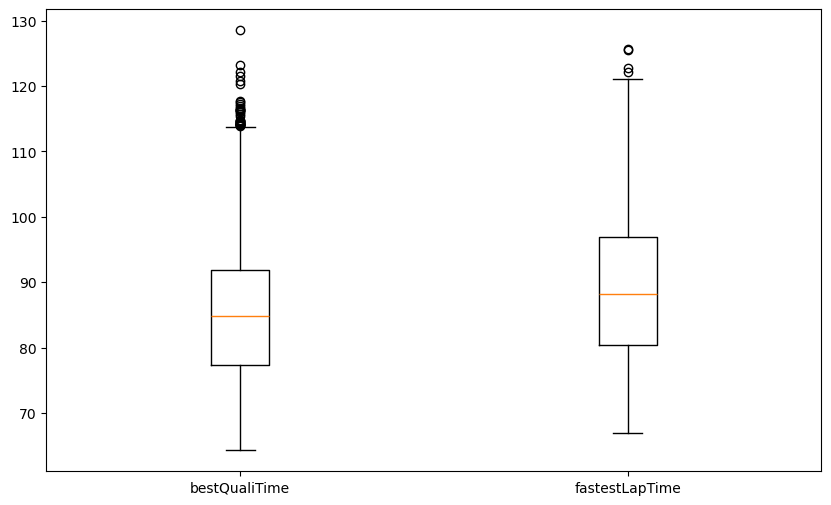

In [233]:
plt.figure(figsize=(10, 6))
plt.boxplot(data[['bestQualiTime', 'fastestLapTime']], tick_labels=['bestQualiTime', 'fastestLapTime']);

# Model Training and Validation

In [234]:
X = data[['bestQualiTime', 'surname', 'name_constructor']]
y = data['fastestLapTime']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [235]:
# TODO: print performance, and model analysis

In [236]:
model = Pipeline([
    ('preproc', ColumnTransformer([
        ('numeric', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(include_bias=False))
        ]), numeric_vars),
        ('categorical', OneHotEncoder(), categorical_vars)
    ])),
    ('regr', Ridge())
])

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8343455672639493

In [237]:
model = Pipeline([
    ('preproc', ColumnTransformer([
        ('numeric', StandardScaler(), numeric_vars),
        ('categorical', OneHotEncoder(), categorical_vars)
    ])),
    ('regr', DecisionTreeRegressor(max_depth=4))
])

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8681740234266662

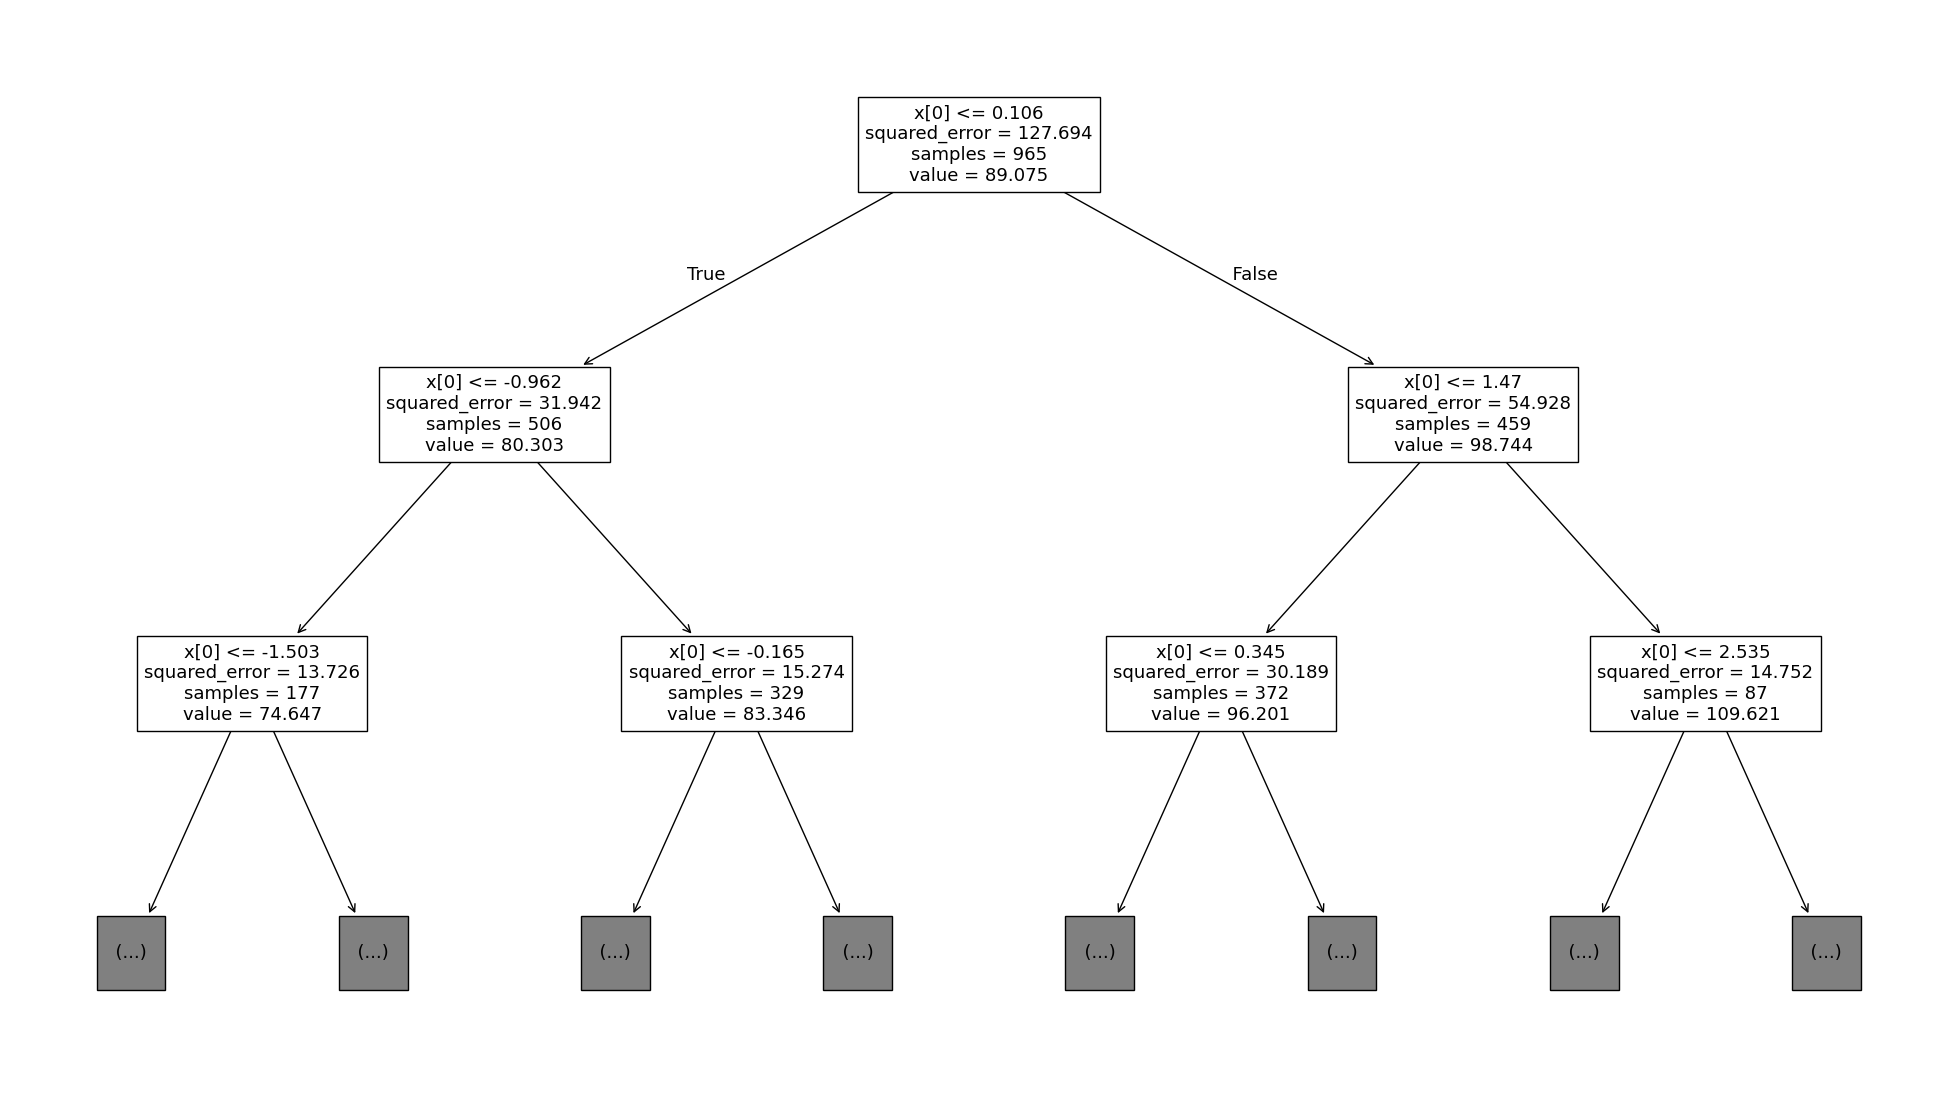

In [238]:
from sklearn.tree import plot_tree

plt.figure(figsize=(25, 14))
plot_tree(model['regr'], max_depth=2);

In [245]:
model = Pipeline([
    ('preproc', ColumnTransformer([
        ('numeric', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(include_bias=False))
        ]), numeric_vars),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_vars)
    ])),
    ('regr', Ridge())
])

grid = {
    'preproc__numeric__scaler': ['passthrough', StandardScaler()],
    "preproc__numeric__poly__degree": np.arange(1, 5),
    'regr__alpha': [0.01, 0.1, 1]
}

kf = KFold(3, shuffle=True, random_state=42)

gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
gs.score(X_test, y_test)

0.8569013320246696

In [246]:
gs.best_params_

{'preproc__numeric__poly__degree': 4,
 'preproc__numeric__scaler': 'passthrough',
 'regr__alpha': 0.01}